In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import random
import keras
from matplotlib import pyplot as plt
import numpy as np
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from keras import optimizers
from keras.utils import multi_gpu_model
from keras import backend as K
from SSD_loss import SSDLoss
from importlib import reload
#import cv2
import pet_data
import detection_nets
import tensorflow as tf
from pet_detector_help import *
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
input_H = 224
input_W = 224
input_C = 3
input_shape = (input_H, input_W, input_C)
data_root = "/home/cai/dataset/pets/"
extras =  ['S', 512 ]
feature_map = [7,7,4,4,2,1]
aspect_ratios = [[2,3],[2,3],[2,3],[2,3],[2],[2]] 
mbox =  [2 + len(ar) * 2 for ar in aspect_ratios]  # number of boxes per feature map location
source_layers=["out_relu"]

In [3]:
annot = data_root + "annotations"

In [8]:
def generate_class_names(annot):
    list_names = open(annot + '/trainval.txt').readlines()
    class_names = []
    for name in list_names:
        name = name.lower()
        p = name.rfind('_')
        if not name[:p] in class_names:
            class_names.append(name[:p])
    print(class_names)
    file = open(os.path.join(annot,'class_names.txt'),'w')
    file.writelines([name + "\n" for name in class_names ])
generate_class_names(annot)
pet_data.split_annotations(data_root,'trainval.txt')

['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
before ignore: 3680
after ignore: 3671


## Read classnames

In [9]:
#read_class_names(annot):
file = open(os.path.join(annot,'class_names.txt'))
lines = open(os.path.join(annot,'class_names.txt')).readlines()
class_names = [name[:-1] for name in lines]
num_classes = len(class_names)
print(class_names)
print('classes num',num_classes)

['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
classes num 37


## Load Dataset

In [10]:
(x_train,y_train_no_process),(x_test,y_test_no_process) = pet_data.load_data(0.4,0.25,root=data_root,task = 'detection')
print("x_train shape",x_train.shape," y_train_no_process shape",y_train_no_process.shape)
print("x_test shape",x_test.shape," y_test_no_process shape",y_test_no_process.shape)

...............done
x_train shape (1101, 224, 224, 3)  y_train_no_process shape (1101, 41)
x_test shape (229, 224, 224, 3)  y_test_no_process shape (229, 41)


## Generate prior boxes and process y

In [11]:
y_train = y_train_no_process.copy()
y_test = y_test_no_process.copy()
#print(y_train.shape,y_test.shape)
#print(y_train[:,0])

## Draw a sample of y_true

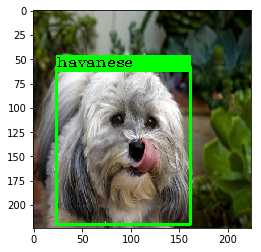

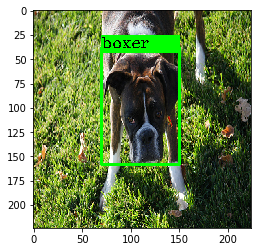

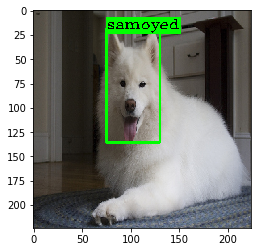

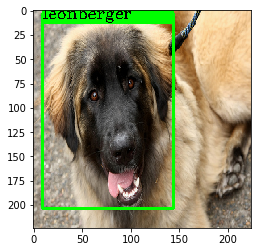

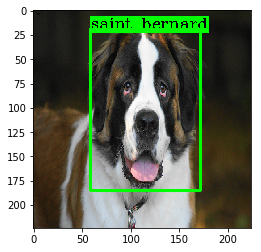

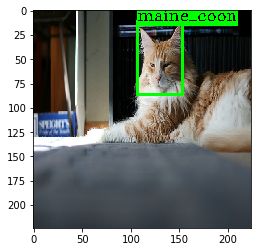

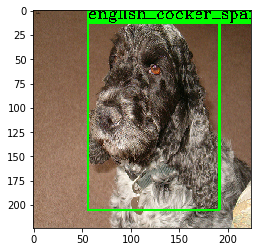

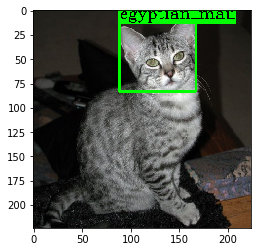

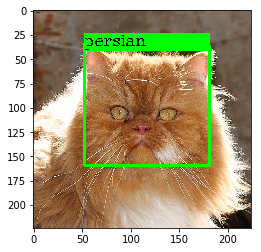

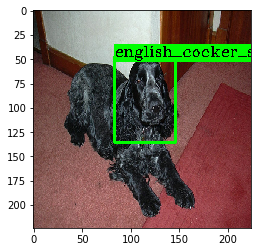

In [61]:
import drawing
reload(drawing)
from drawing import *
for i in range(0,10):
    x = x_train[i].copy()
    y = y_train_no_process[i].copy()
    #print(y_train_no_process[:,1])
    frame= (x * 255).astype('int32')
    draw_detection(frame,y,class_names,box_color=(0,255,0),font_scale =0.5,draw_label=True)
    plt.imshow(frame)
    plt.show()

## Define Loss Function

In [112]:
def Loss(y_true,y_pred):
    log_loss = -tf.reduce_mean(tf.reduce_sum(y_true[:,:-4] * tf.log(y_pred[:,:-4]), axis=-1))
    mse_loss = tf.reduce_sum(tf.square(y_true[:,-4:] - y_pred[:,-4:]))
    total_loss = log_loss #+ mse_loss
    return total_loss

### Set hyper params

In [113]:
reload(detection_nets)
base_name = "mobilenetv2"
version_name = ""
source_name ="out_relu"
build_model = detection_nets.build_double_tail_detection_net
show_summary = True
#Train
phase = 'training' #training or testing
epochs_per_stage = 8
stages = 4
epoch_decay = 5
batch_size = 4
verbose = True
use_data_augment = False
plot = False
#Environment
#clear_session = True
#Learning params
lr=1e-3
decay=1e-6
momentum=0.9
validation_split = 0.25
load_weights = False
save_weights = False
check_point = 1
save_path = 'saved_weights'
log_file = "log"
log = True


In [107]:
def freeze(model,num):
    for i in range(num):
        model.get_layer(index=i).trainable = False
#freeze(base_model,50)


### Build model with a backbone

In [114]:
#loss = SSDLoss().compute_loss

if phase!='testing' and phase!='training':
    raise RuntimeError("Phase must be either testing or training")
if epochs_per_stage < 1:
    raise RuntimeError("Epochs per stage must be greater than 1")
if stages < 1:
    raise RuntimeError("Stages must be greater than 1")
if phase == 'testing' and load_weights != True:
    print("Warning: phase is testing and load weights is not True")
if phase == 'training' and load_weights == False and check_point != 1:
    print("Warning: Initial check point should be 1")
    check_point = 1
if not os.path.isdir(save_path):
    os.mkdir(save_path)

loss = Loss
base_model =  keras.applications.mobilenet_v2.MobileNetV2(input_shape=(input_H,input_W,input_C), alpha=1.0, 
                                                          depth_multiplier=1, include_top=True, 
                                                          weights='imagenet', input_tensor=None, pooling=None, classes=1000)
#freeze(base_model,50)
model_name,model = build_model(base_model,source_name,num_classes,version_name,base_name)
model.compile(loss=loss,optimizer=optimizers.SGD(lr=lr,decay=decay,momentum=momentum))
if show_summary:
    model.summary()
print(model_name,'has been built ')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

#### Check y train、y_test and output of model should have the same shape

In [115]:
print(model.output.get_shape(),y_train.shape)
assert((np.array(model.output.get_shape().as_list()[1:]) == np.array(y_train.shape[1:])).all())
assert((np.array(model.output.get_shape().as_list()[1:]) == np.array(y_test.shape[1:])).all())

(?, 41) (1101, 41)


## Train or test

In [116]:
file.close()
if log:
    file = open(log_file,'a+')
if load_weights:
    model.load_weights(save_path + '/' + model_name + '_' + str(check_point) + ".h5")
    print("weights loaded from check point",check_point)
    if phase == 'training':
        check_point += 1
if phase == 'training':
    info =('model name' ,model_name , \
           '\nstart fitting.. ' , '\nstages:' , stages, ' epochs_per_stage:',epochs_per_stage, ' plot_history:' ,plot,\
           '\ntrainset size:', len(y_train), ' validation_split:',validation_split,\
           '\nlearning rate:' ,lr  ,' decay:' ,decay , ' momentum:' ,momentum ,  \
           '\ninitial checkpoint:', check_point ,  \
           '\nload weight:' ,load_weights)
    if verbose:
        print(*info)
    if log:
        print(*info,file=file)
    epochs = epochs_per_stage
    for i in range(1,1+stages):
        if verbose:
            print("Stage ",i,"/",stages)
            print("Epoch num",epochs)
        if log:
            print("Stage ",i,"/",stages,file=file)
            print("Epoch num",epochs,file=file)
        history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs, verbose = verbose, validation_split = validation_split)
        #fit_generator(model,x_train,y_train)
        path = save_path + '/' + model_name + '_' + str(check_point) + ".h5"
        if save_weights:
            if verbose:
                print("save at",path)
            model.save_weights(path)
            check_point += 1 
        ac = evaluate(model,x_test,y_test)
        if verbose:
            print(ac)
        if log:
            print(ac,file=file)
        if plot:
            plot_history(history)
        epochs = epochs - epoch_decay // stages
elif phase =='testing':
    if verbose:
        print('start evaluating')
    loss = model.evaluate(x=x_test,y=y_test)
    ac = evaluate(model,x_test,y_test)
    if verbose:
        print('loss',round(result,5))
        print('ac',ac)
    if log:
        print('loss',round(result,5),file=file)
        print('ac',ac,file=file)
    
   # model.save_weights(model_name + ".h5")

model name double_tail_detection_mobilenetv2_ 
start fitting..  
stages: 4  epochs_per_stage: 8  plot_history: False 
trainset size: 1101  validation_split: 0.25 
learning rate: 0.001  decay: 1e-06  momentum: 0.9 
initial checkpoint: 1 
load weight: False
Stage  1 / 4
Epoch num 8
Train on 825 samples, validate on 276 samples
Epoch 1/8
825/825 [==============================] - 58s 70ms/step - loss: 3.6616 - val_loss: 7.6639
Epoch 2/8
825/825 [==============================] - 19s 23ms/step - loss: 3.6067 - val_loss: 3.6467
Epoch 3/8
825/825 [==============================] - 18s 22ms/step - loss: 3.4424 - val_loss: 3.6527
Epoch 4/8
825/825 [==============================] - 19s 23ms/step - loss: 3.1774 - val_loss: 3.5079
Epoch 5/8
825/825 [==============================] - 19s 23ms/step - loss: 3.0114 - val_loss: 3.6035
Epoch 6/8
825/825 [==============================] - 19s 23ms/step - loss: 2.5938 - val_loss: 3.9987
Epoch 7/8
825/825 [==============================] - 19s 23ms/step 

KeyboardInterrupt: 

In [ ]:
file.close()

In [111]:
result = model.evaluate(x=x_test,y=y_test)
print('loss',round(result,5))
print(evaluate(model,x_test,y_test))

229/229 [==============================] - 1s 2ms/step
loss 5.3109
{'class accuracy': 0.1397, 'loc accuracy': 0.2838, 'accuracy ': 0.0349}


*Set hyper params and run all above from here*


#### Select a test image and do the prediction

In [46]:
cats_idx = np.where(y_test[:,0] == 1)[0]
test_idx = [0,1,2,3,4,5,6,7,100,101,102,200,201]
x = x_test
y = y_test
y_pred_no_process = model.predict(x[test_idx])
y_pred = y_pred_no_process.copy()

## Draw for single object detection

image:  0
(224, 224, 3)
loc pred [0.308 0.013 0.789 0.523]
class pred chihuahua score 0.9059549
loc truth [0.287 0.004 0.623 0.476]
class truth miniature_pinscher


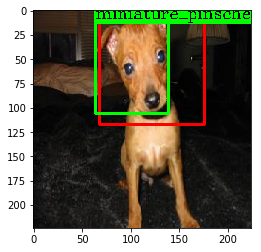

image:  1
(224, 224, 3)
loc pred [0.373 0.213 0.684 0.677]
class pred keeshond score 0.9562001
loc truth [0.354 0.165 0.672 0.73 ]
class truth keeshond


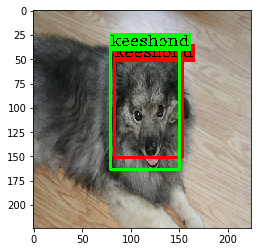

image:  2
(224, 224, 3)
loc pred [0.194 0.017 0.974 0.717]
class pred russian_blue score 0.80536485
loc truth [0.007 0.006 0.904 0.58 ]
class truth russian_blue


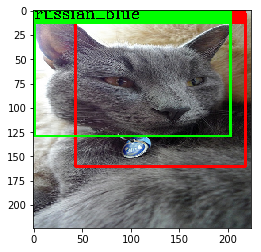

image:  3
(224, 224, 3)
loc pred [0.42  0.306 0.727 0.734]
class pred american_bulldog score 0.1748237
loc truth [0.548 0.352 0.708 0.627]
class truth english_setter


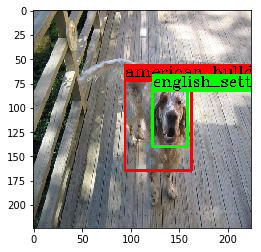

image:  4
(224, 224, 3)
loc pred [0.377 0.08  0.758 0.458]
class pred chihuahua score 0.64308304
loc truth [0.34  0.004 0.82  0.44 ]
class truth miniature_pinscher


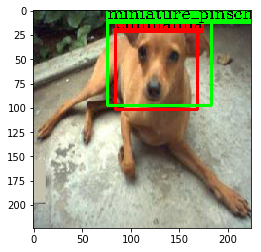

image:  5
(224, 224, 3)
loc pred [0.209 0.128 0.717 0.628]
class pred staffordshire_bull_terrier score 0.7107674
loc truth [0.176 0.123 0.726 0.82 ]
class truth american_pit_bull_terrier


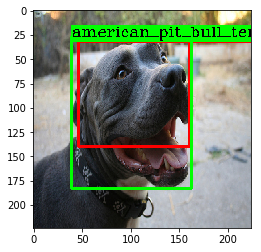

image:  6
(224, 224, 3)
loc pred [0.163 0.13  0.773 0.658]
class pred pomeranian score 0.6070199
loc truth [0.178 0.117 0.809 0.67 ]
class truth pomeranian


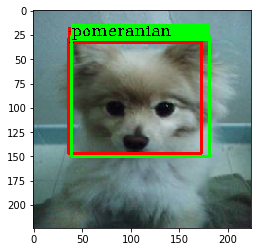

image:  7
(224, 224, 3)
loc pred [0.082 0.012 0.901 0.695]
class pred siamese score 0.9997141
loc truth [0.003 0.002 1.    0.688]
class truth siamese


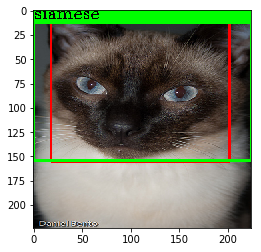

image:  8
(224, 224, 3)
loc pred [0.251 0.169 0.717 0.531]
class pred yorkshire_terrier score 0.9998665
loc truth [0.264 0.177 0.718 0.56 ]
class truth yorkshire_terrier


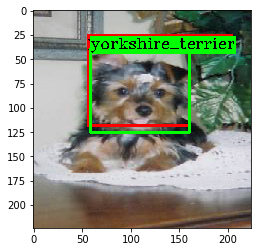

image:  9
(224, 224, 3)
loc pred [0.341 0.31  0.621 0.655]
class pred miniature_pinscher score 0.22768041
loc truth [0.276 0.275 0.638 0.779]
class truth staffordshire_bull_terrier


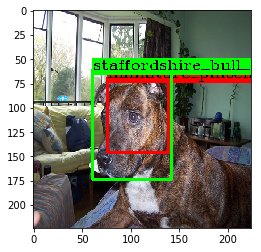

image:  10
(224, 224, 3)
loc pred [0.49  0.412 0.642 0.489]
class pred american_pit_bull_terrier score 0.37813073
loc truth [0.483 0.324 0.733 0.464]
class truth pug


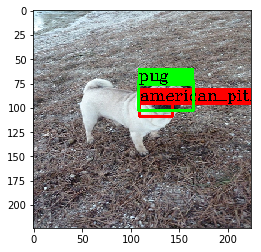

image:  11
(224, 224, 3)
loc pred [0.646 0.311 0.855 0.502]
class pred bengal score 0.4290149
loc truth [0.598 0.211 0.952 0.533]
class truth german_shorthaired


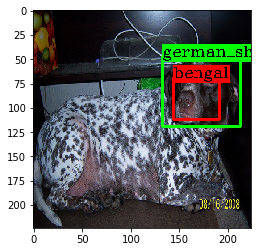

image:  12
(224, 224, 3)
loc pred [0.46  0.31  0.815 0.647]
class pred staffordshire_bull_terrier score 0.13729419
loc truth [0.557 0.316 0.887 0.733]
class truth pug


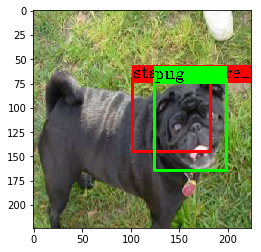

In [47]:
for k,prediction  in enumerate(y_pred):
    #print(prediction)
    # Extract x from test set
    print("image: ",k)
    frame = (x[test_idx[k]] * 255).astype('int32')
    print(frame.shape)
    score = np.max(prediction[:-4])
    spec = np.argmax(prediction[:-4])
    print('loc pred',np.round(prediction[-4:],3))
    print('class pred',class_names[spec],'score',score)
    y_true = y[test_idx[k]]
    spec = np.argmax(y_true[:-4])
    print('loc truth',np.round(y_true[-4:],3))
    print('class truth',class_names[spec])
    draw_detection(frame,prediction,class_names)
    draw_detection(frame,y[test_idx[k]],class_names,box_color = (0,255,0))
    plt.imshow(frame)
    plt.show()

## Draw for multiobject detection

In [45]:
for k,prediction  in enumerate(y_pred):
    #print(prediction)
    # Extract x from test set
    print("image: ",k)
    frame = (test_set[0][test_idx[k]]*255).astype('int32')
    for c,detections in enumerate(prediction):
        if len(detections) == 0:
            continue
        class_name = class_names[c]
        for detection in detections:
            score = detection[0]
            bbox = detection[1:] * input_H#corner
            print(class_name,score,bbox)
            bbox = bbox.astype('int32')
            draw_detection(frame,bbox,score,class_name,box_width = 3)
    plt.imshow(frame)
    plt.show()

NameError: name 'y_pred' is not defined

In [ ]:
img_file = "data/cat1.png"
img = cv2.imread(img_file)
print(img.shape)
x = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = np.array(x,dtype='float')
x = x / 255
y_pred = model.predict(np.expand_dims(x,0))[0]
print(y_pred)
draw_detection(img,y_pred,class_names,box_width=5,font_scale=1)
plt.imshow(img)

In [ ]:
video_file = "data/cats_video.mp4"
result_file = "res.avi"
cap= cv2.VideoCapture(video_file)
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
frames = (int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Input Video Size:',size,' Fps:',fps,' Frames:',frames)
writer = cv2.VideoWriter(result_file,cv2.VideoWriter_fourcc(*'MJPG'), fps, size)
success,frame = cap.read()
count = 1
while success:
    x = cv2.resize(frame,dsize=(input_H,input_W),interpolation=cv2.INTER_CUBIC)
    x = x / 255
    y_pred = model.predict(np.expand_dims(x,0))[0]
    draw_detection(frame, y_pred,class_names,font_scale = 1)
    writer.write(frame)
    cv2.waitKey(1)
    count += 1
    if count%50==0:
        plt.imshow(frame)
        plt.show()
        print('.',end='')
    success,frame = cap.read()
print('done')